In [2]:
import numpy as np
import matplotlib.pyplot as plt
import cv2 as cv
import os
import time
import math

%load_ext Cython

The Cython extension is already loaded. To reload it, use:
  %reload_ext Cython


In [3]:
#v=list(os.walk('./zdjs/light_set'))
v=list(os.walk('./zdjs/pdfs'))

f=[0]*200
j=0
for i in range(0, len(v)):
    for x in (v[i][2]):
        f[j]=cv.imread(v[i][0]+'/'+x, cv.IMREAD_GRAYSCALE)
        j+=1
        
def grave(img, biw=0):
    fig, ax=plt.subplots(1,1,figsize=(22,22))
    if (biw==1):
        ax.imshow(img, cmap='Greys',  interpolation='nearest')
    else:
        ax.imshow(img)
    plt.show()

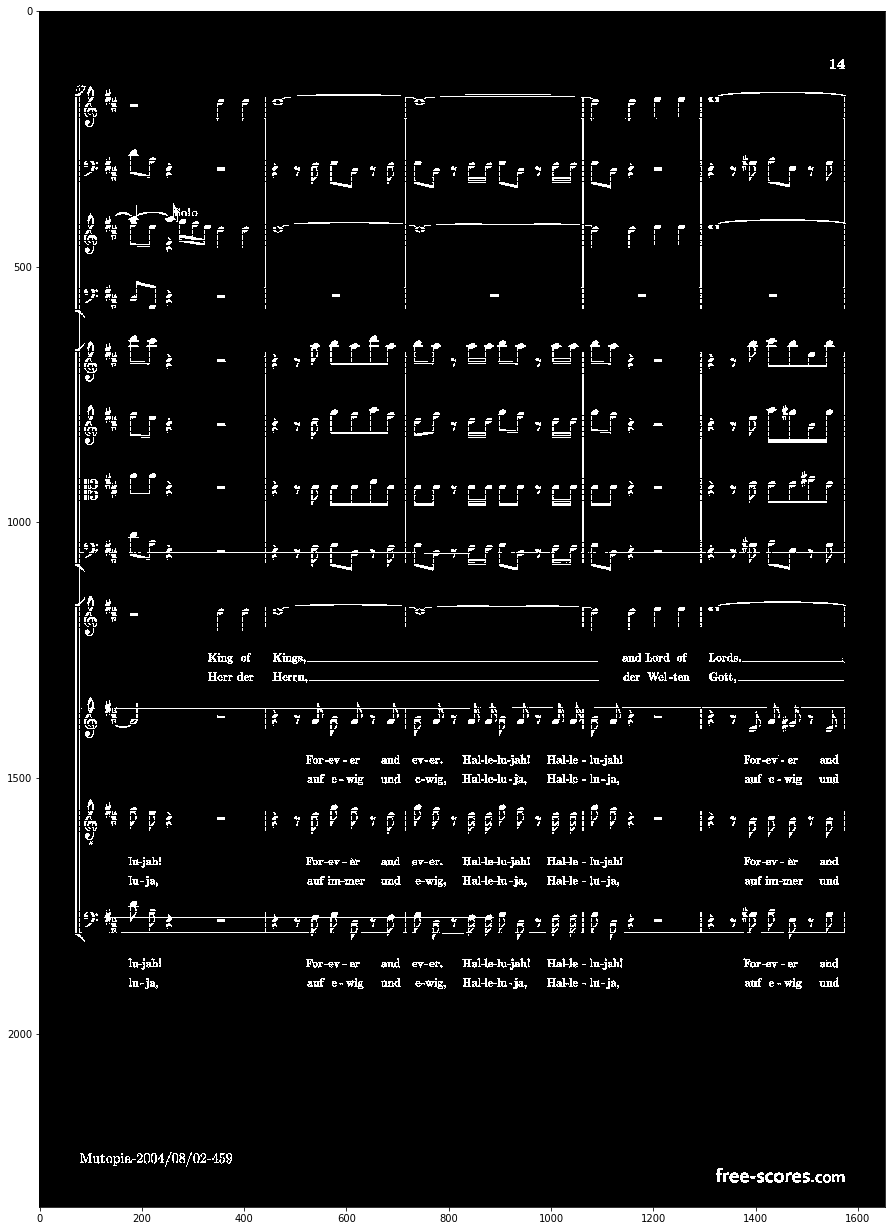

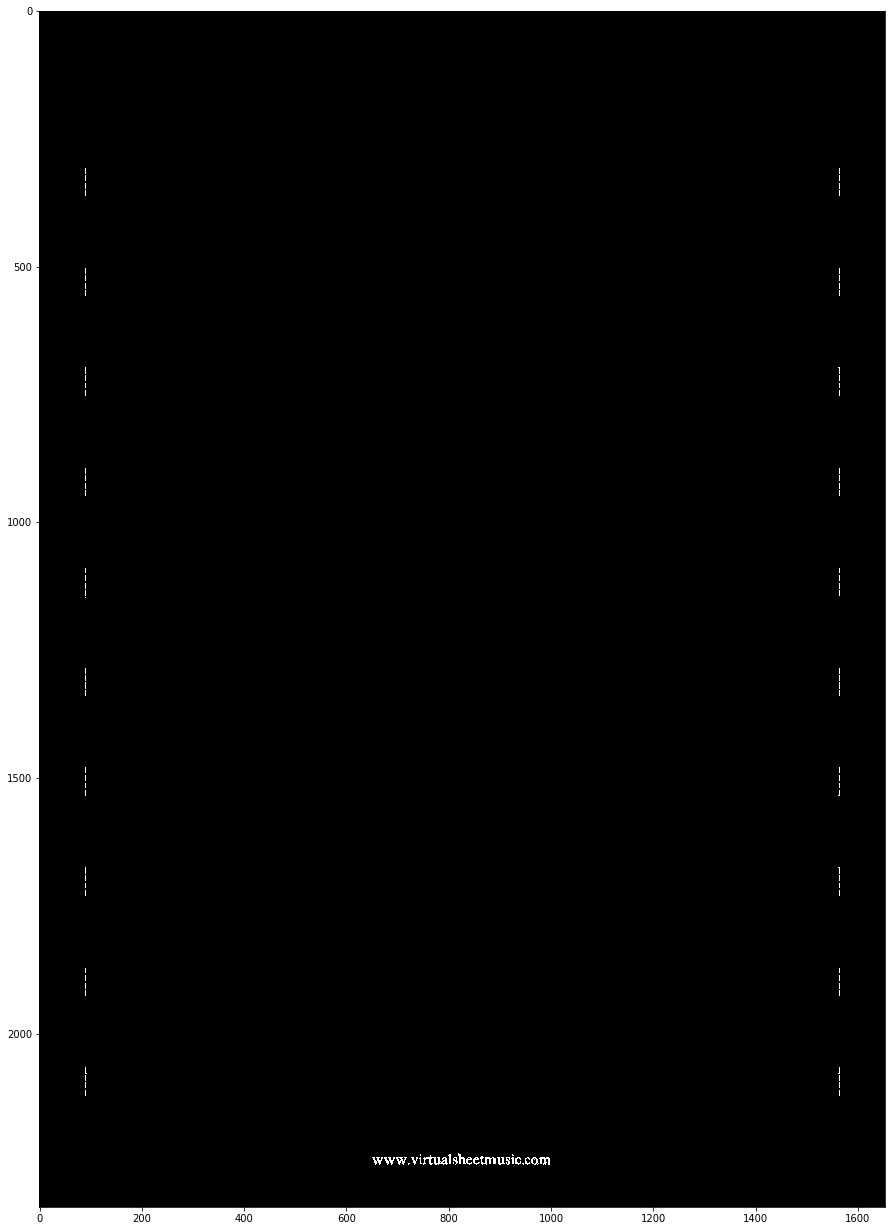

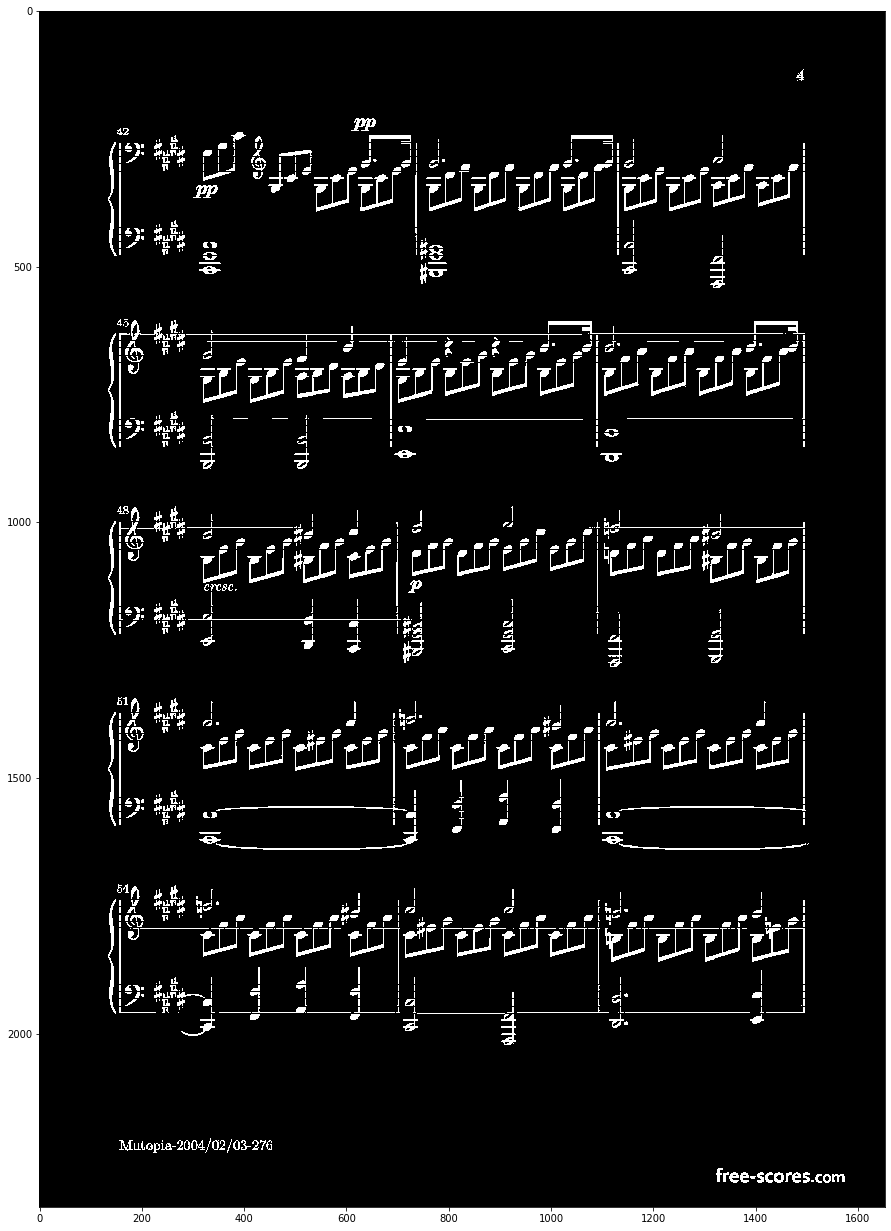

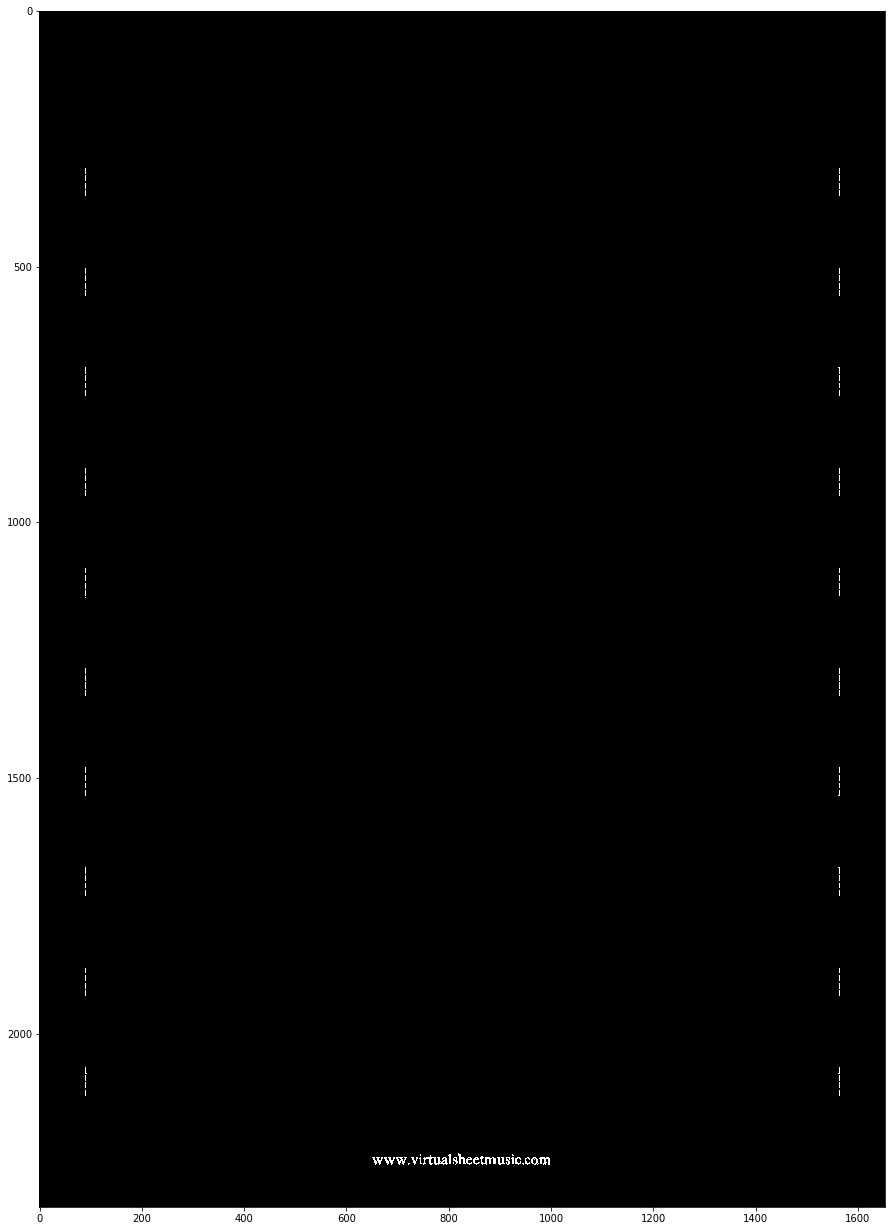

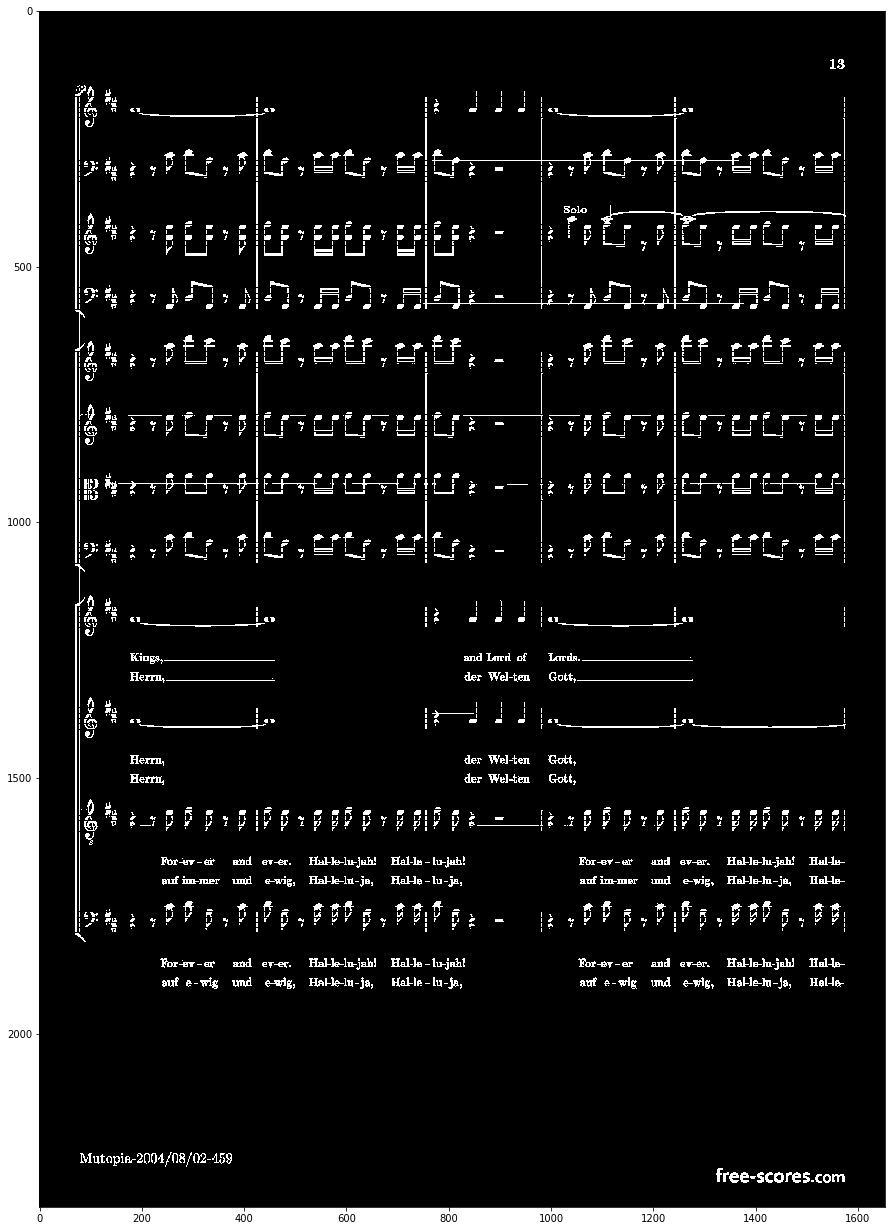

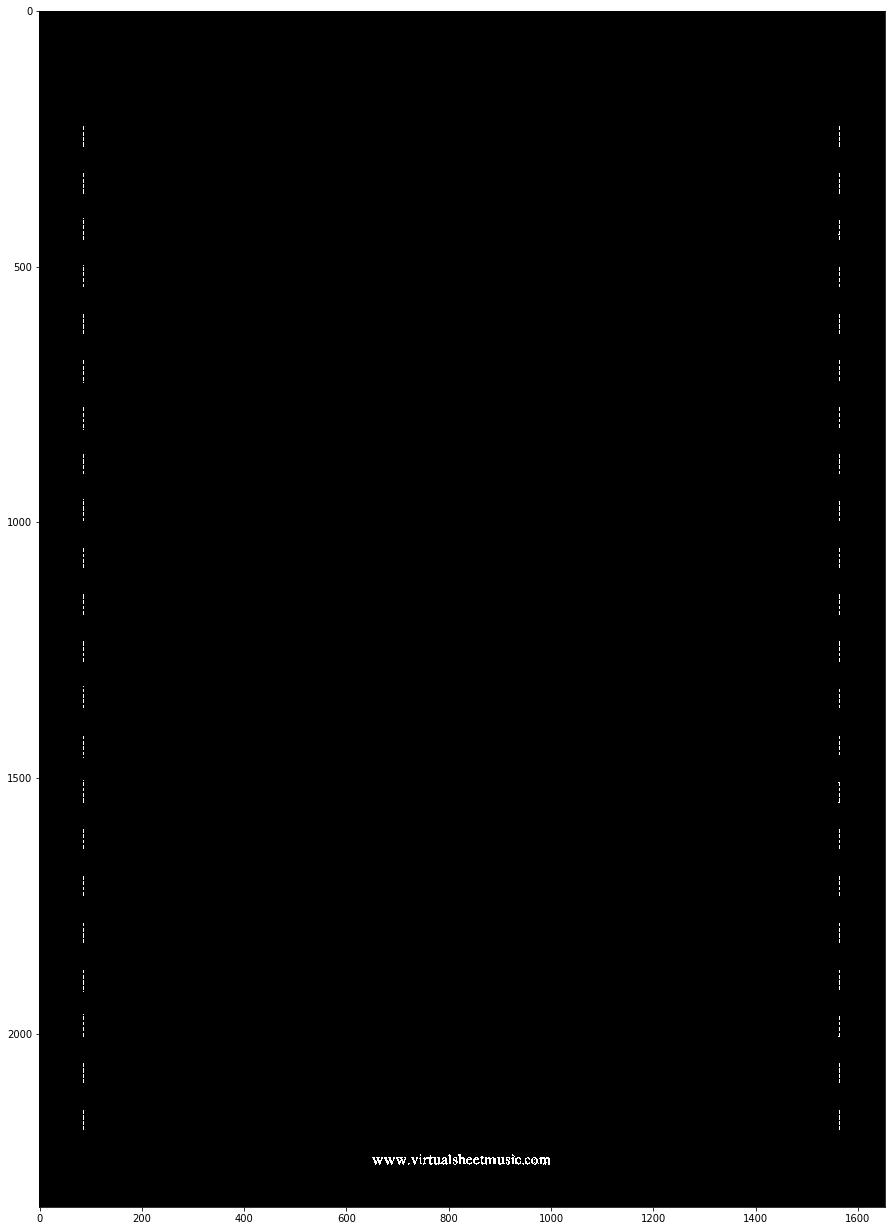

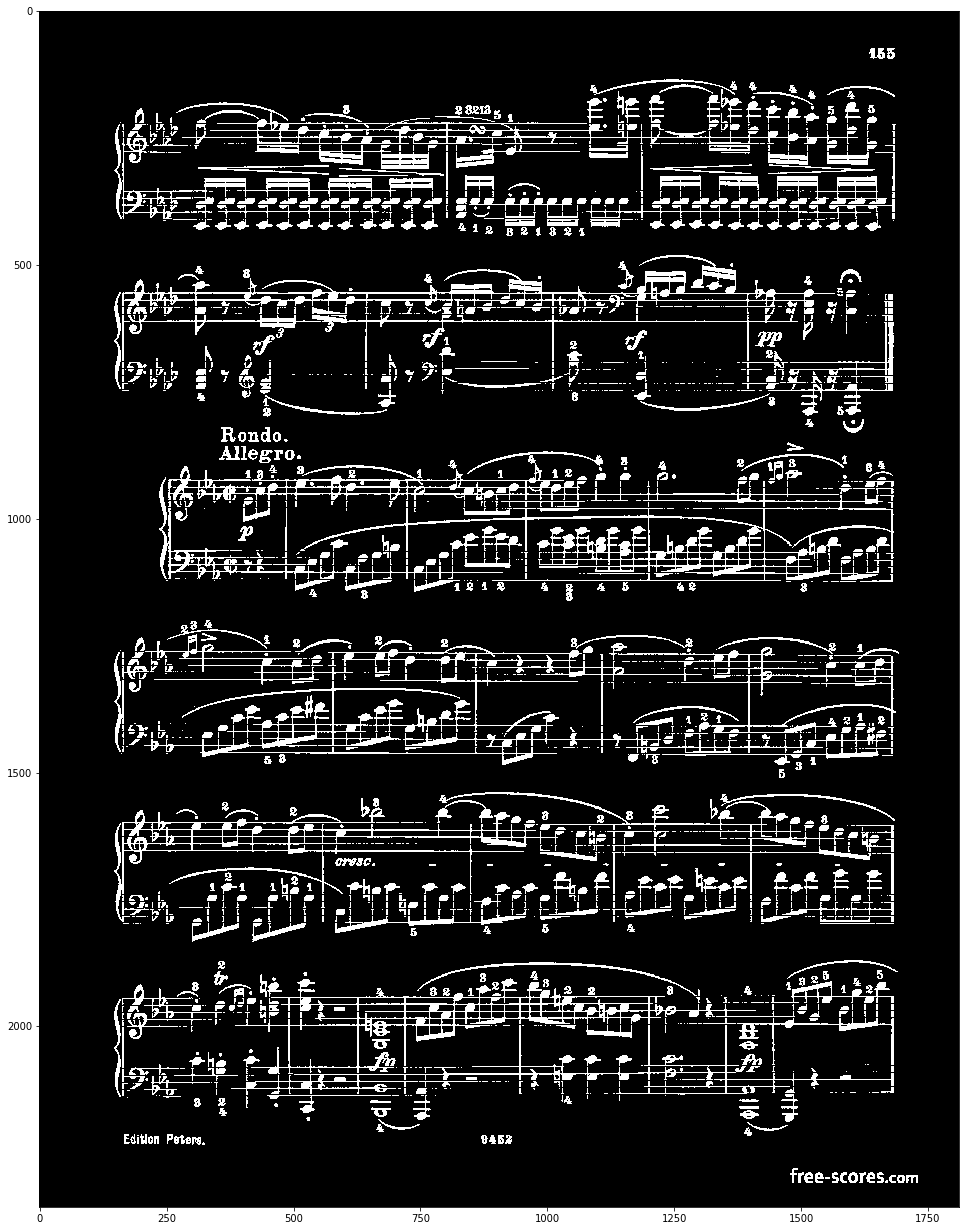

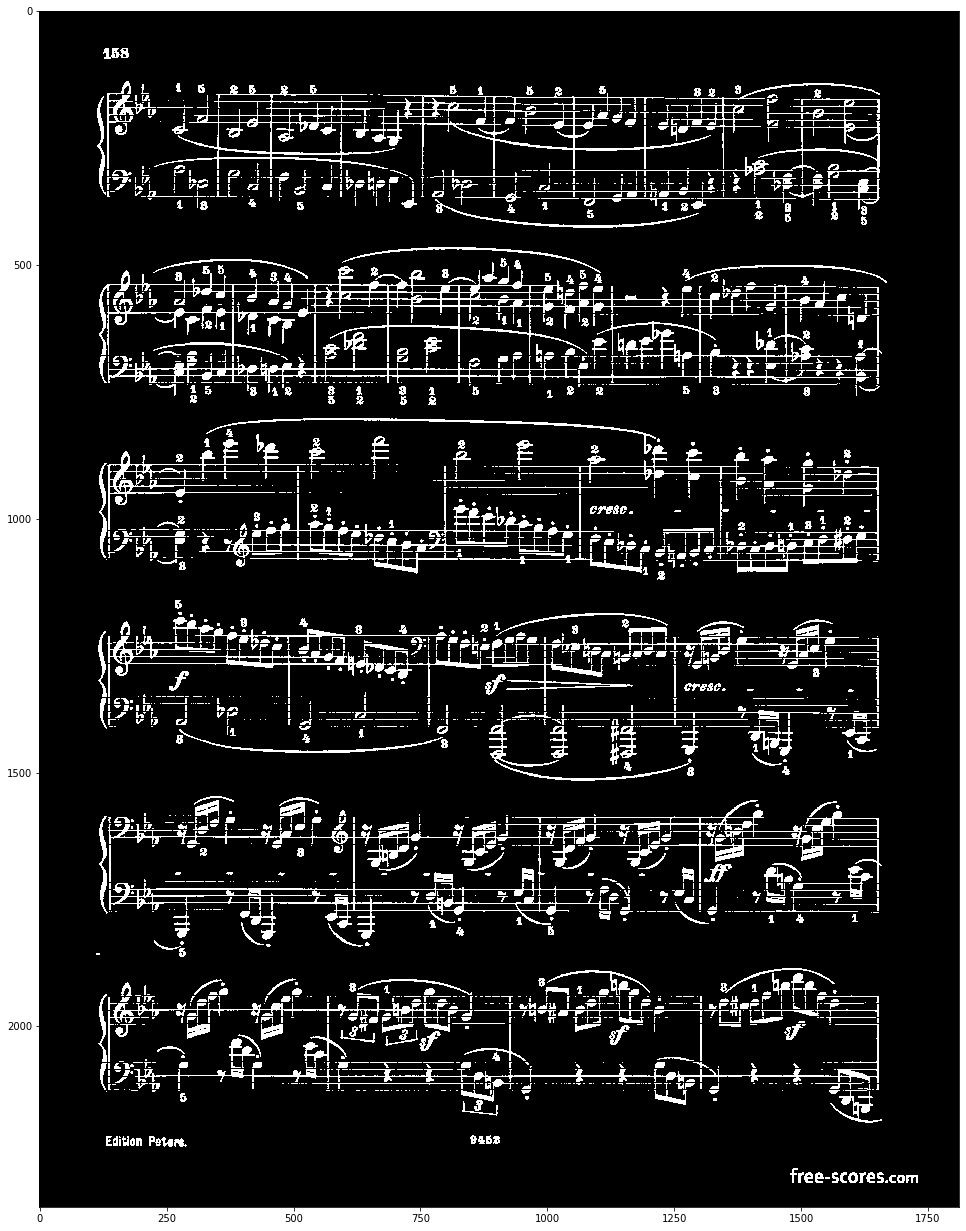

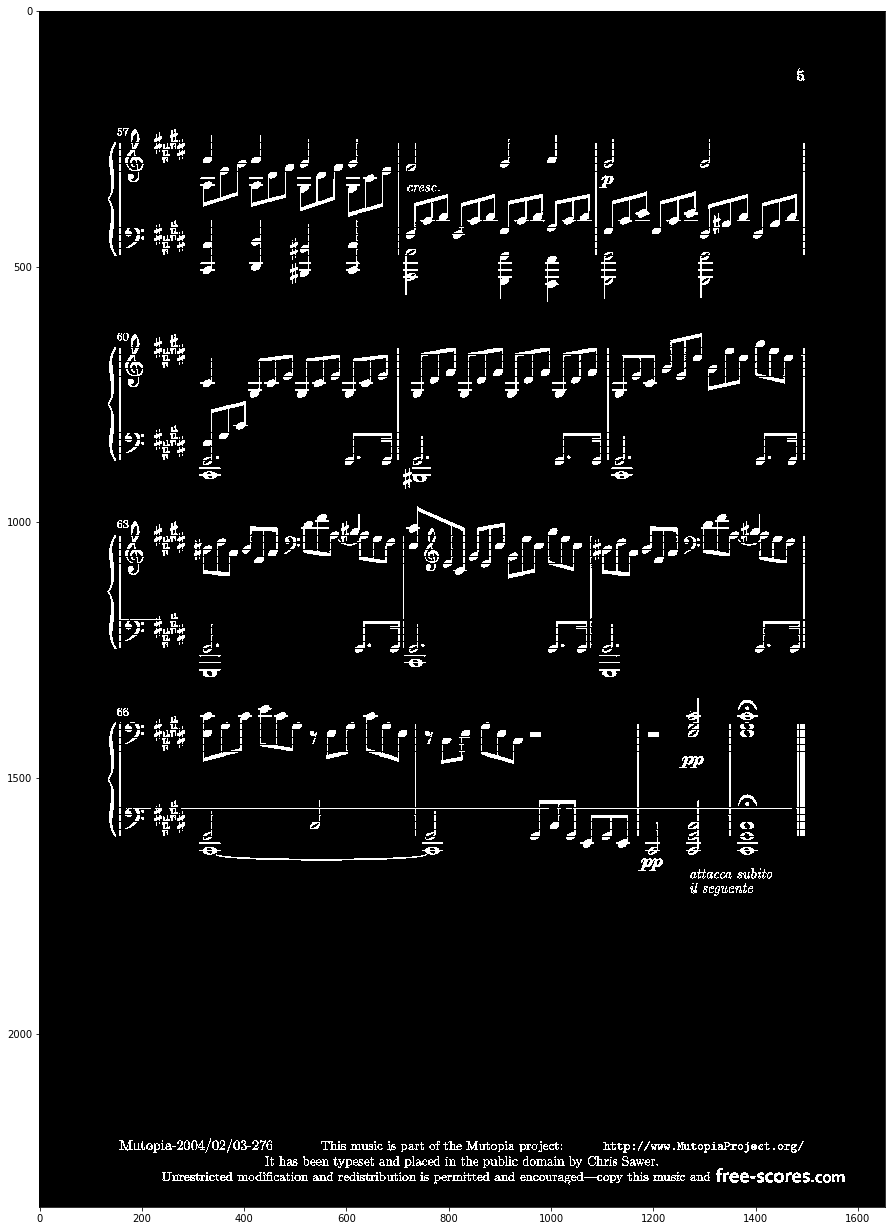

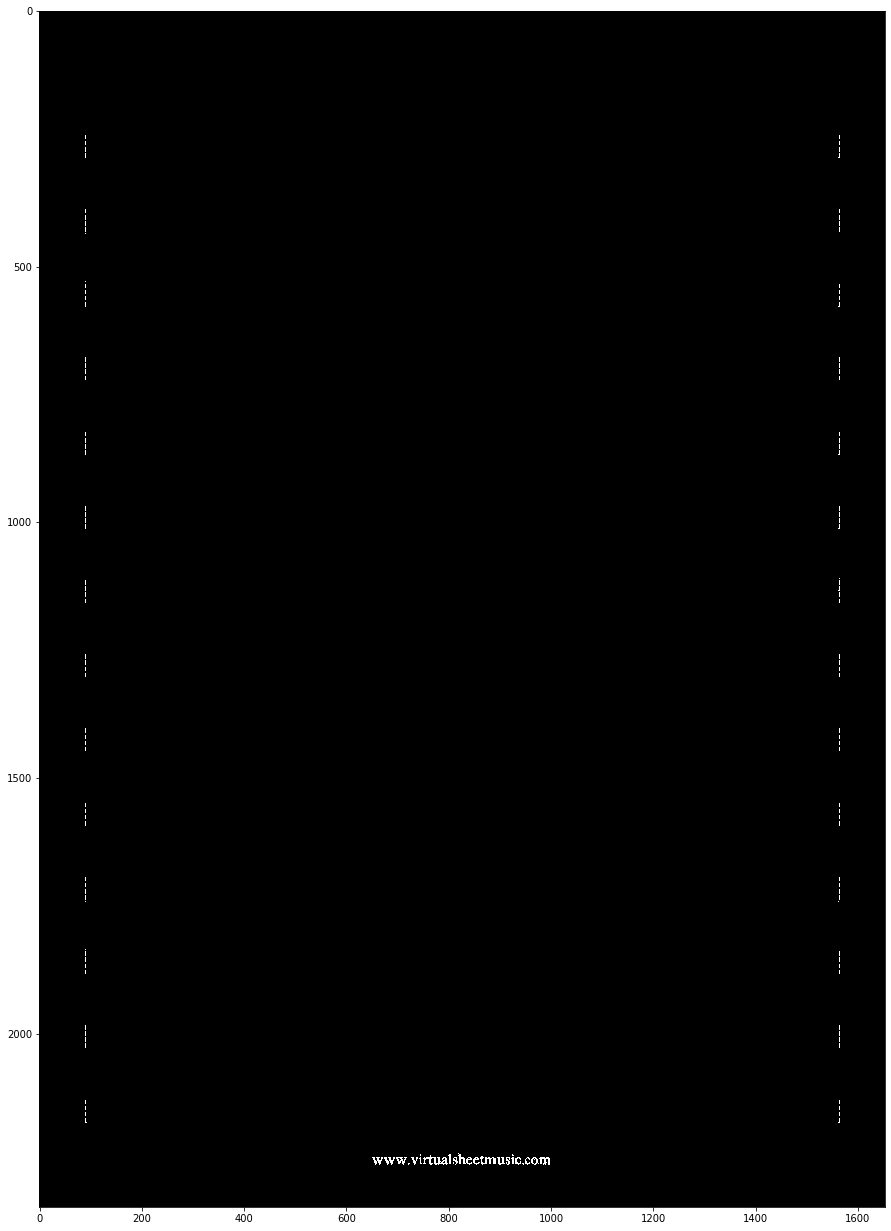

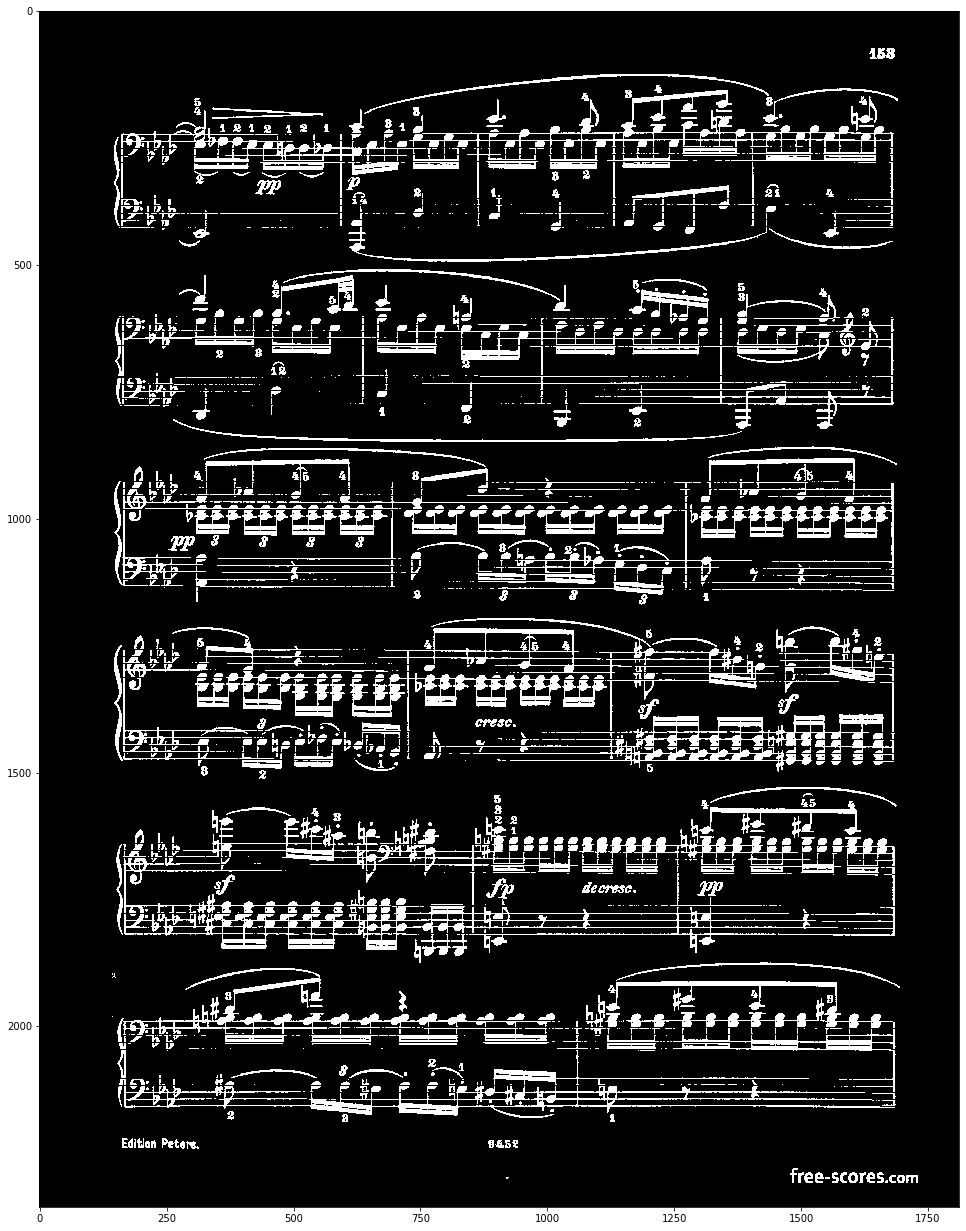

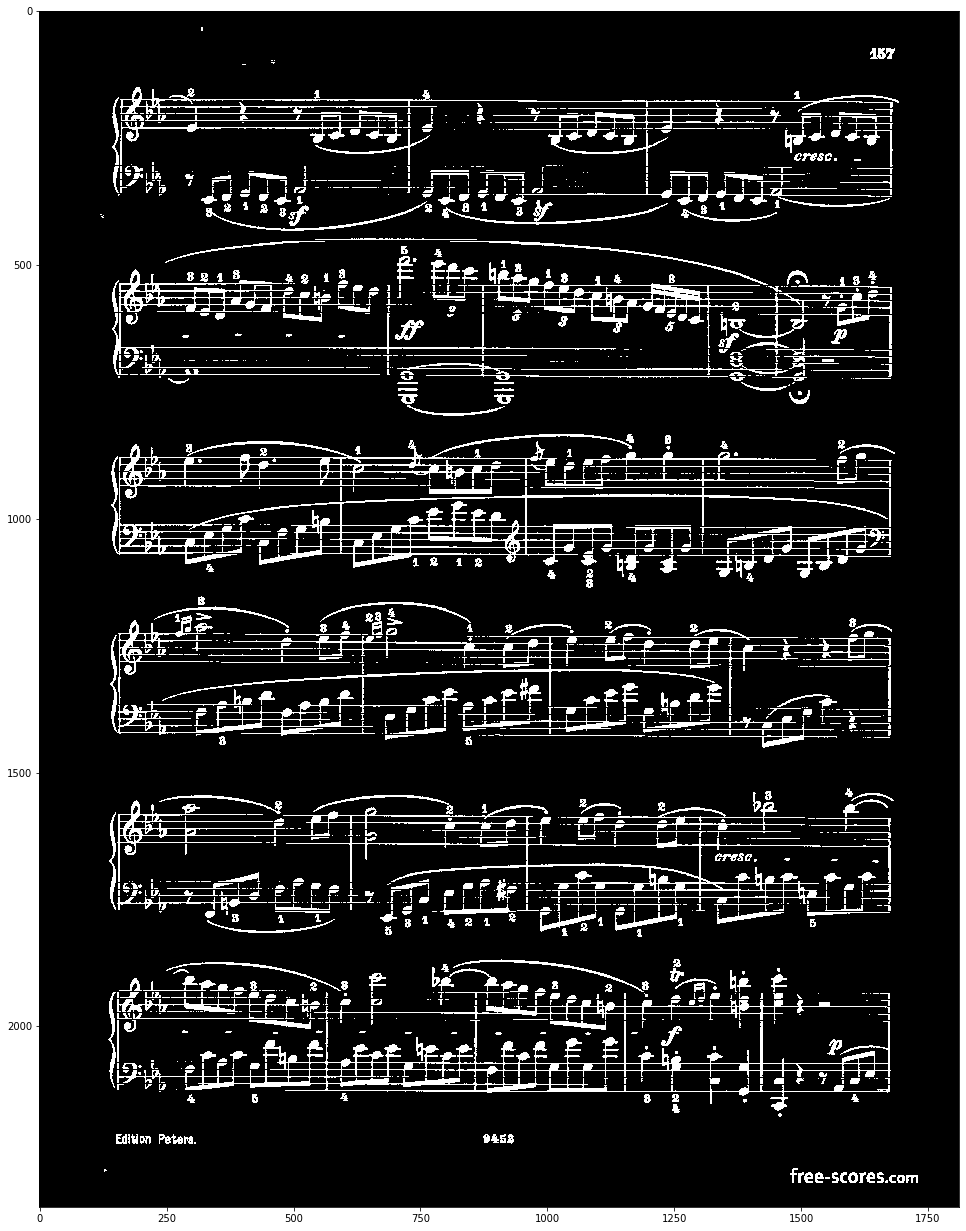

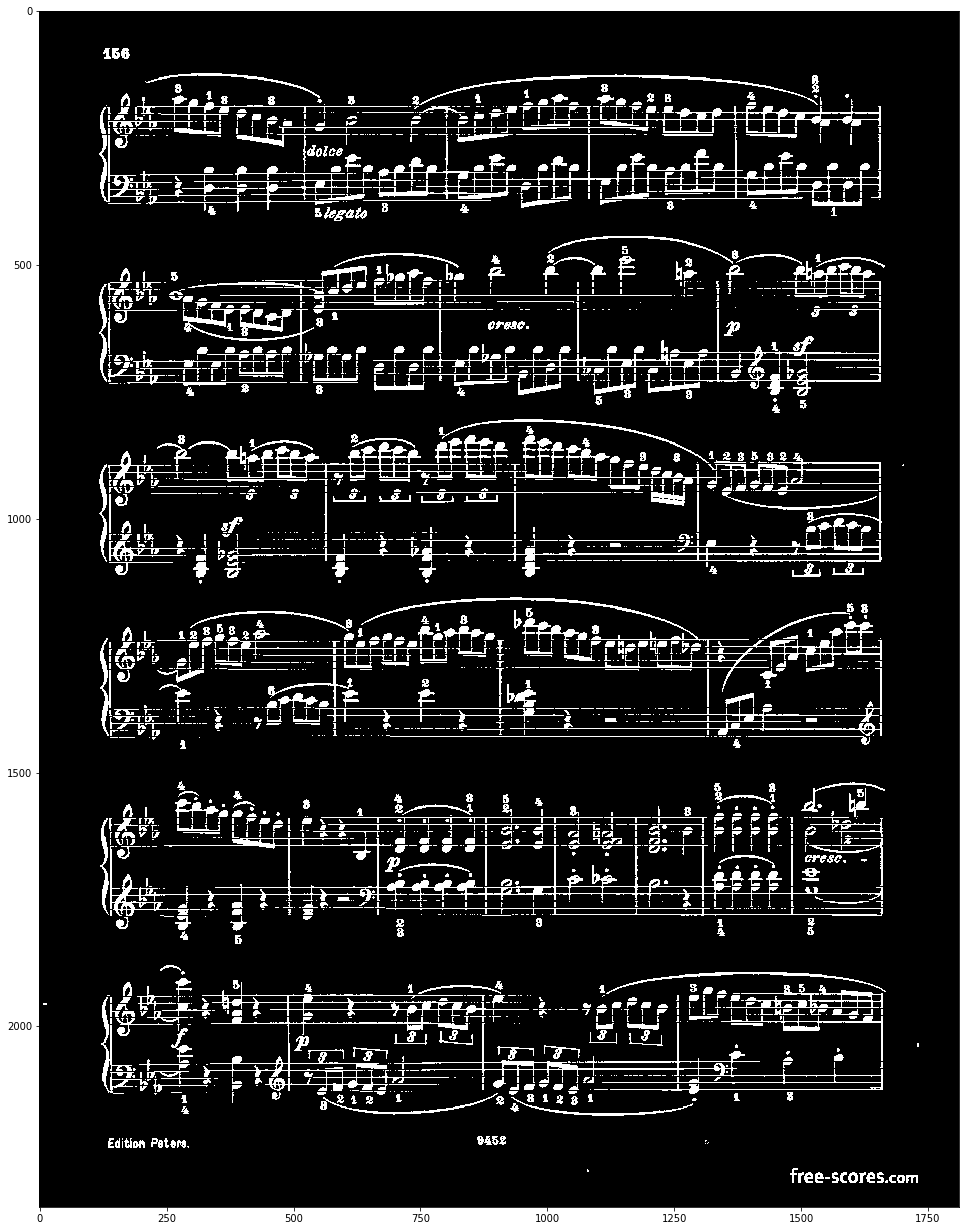

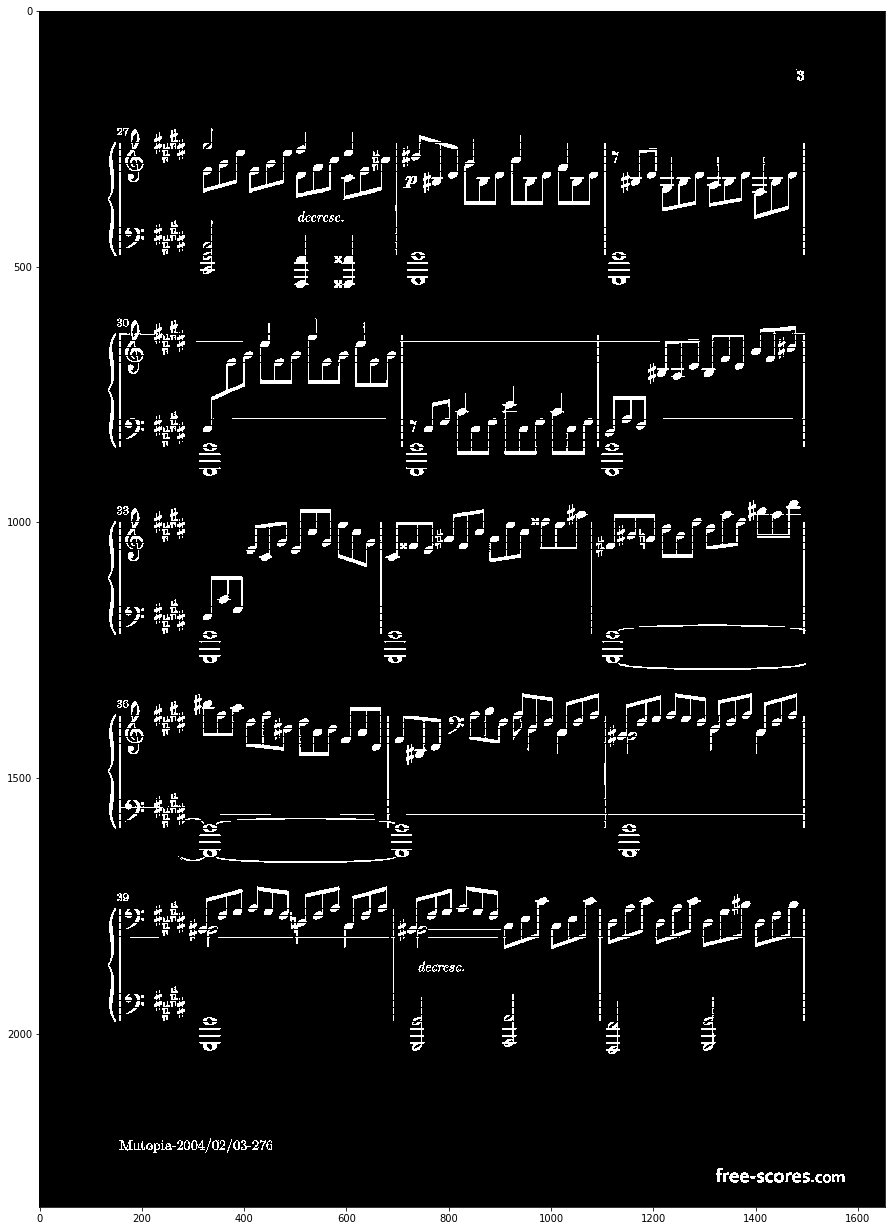

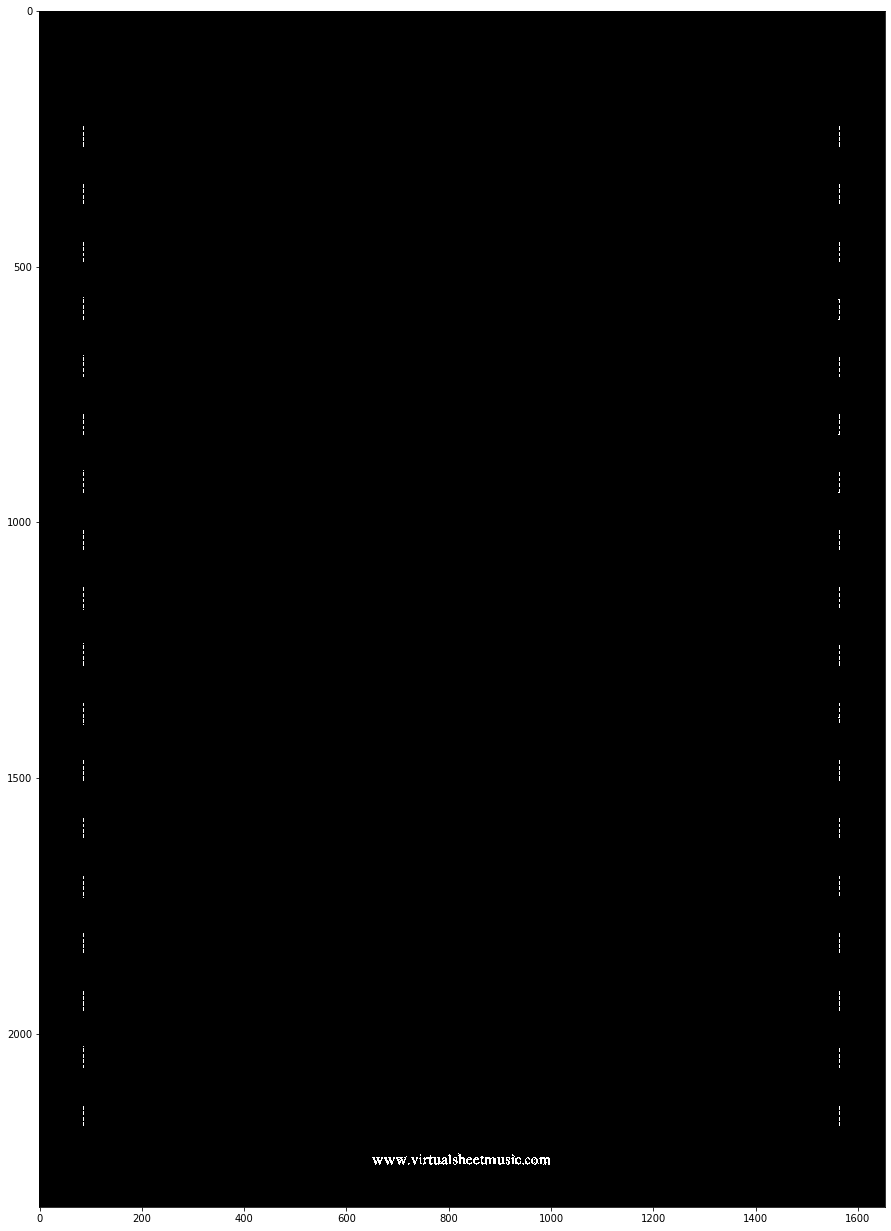

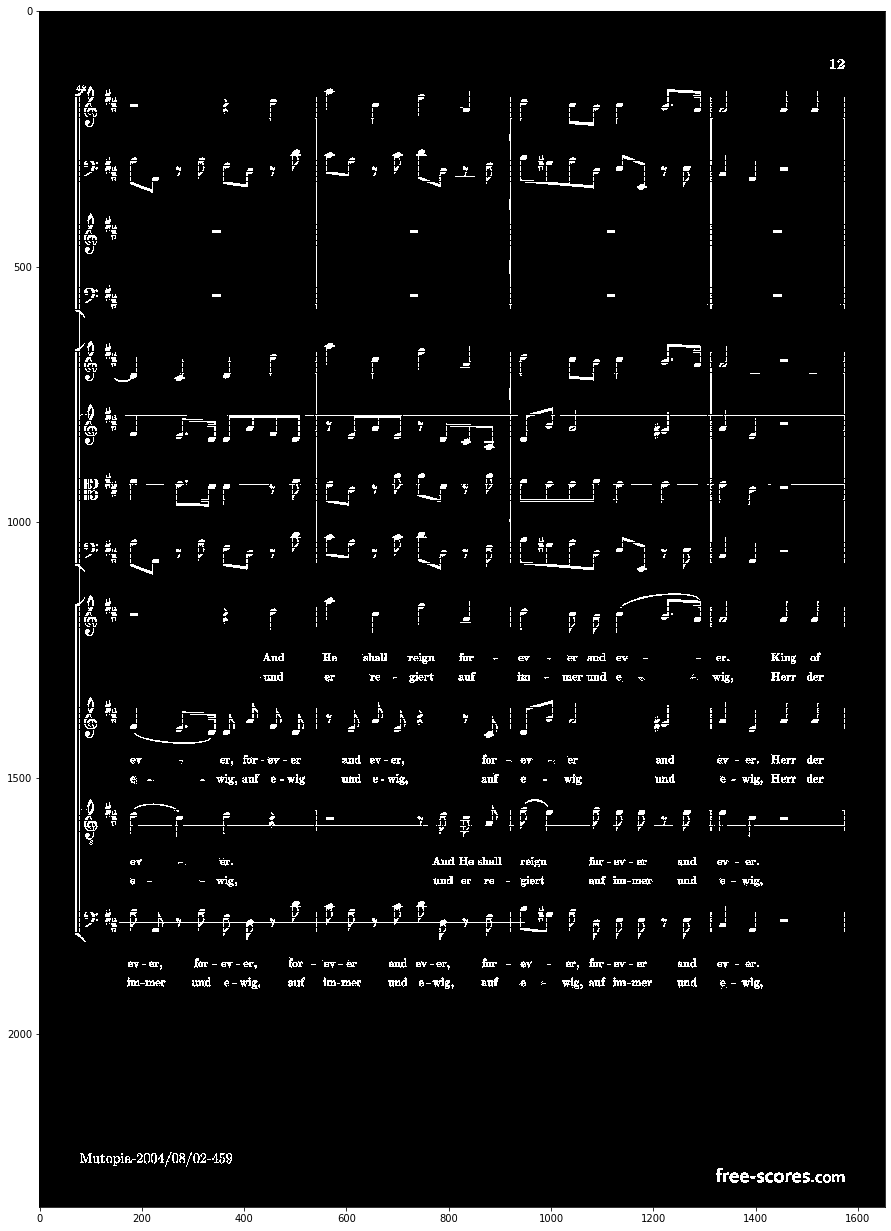

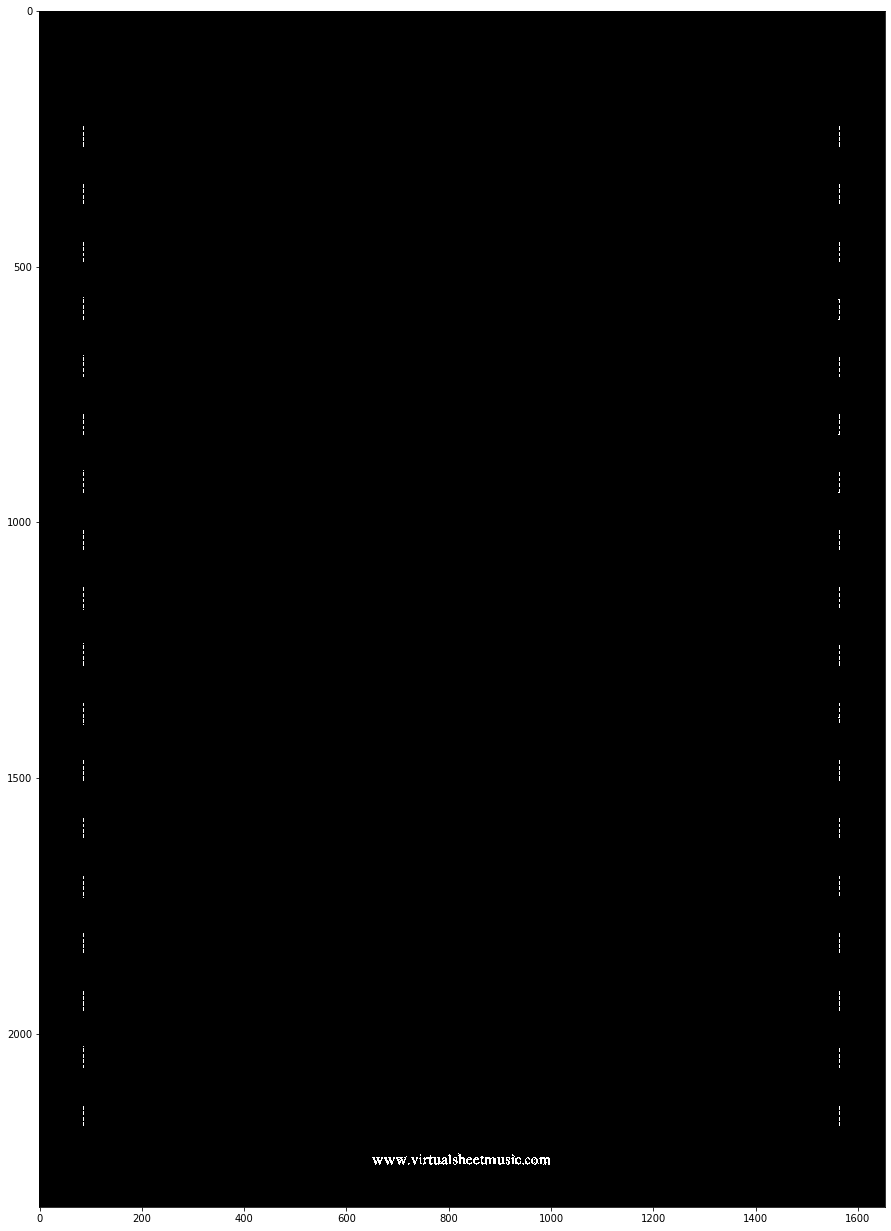

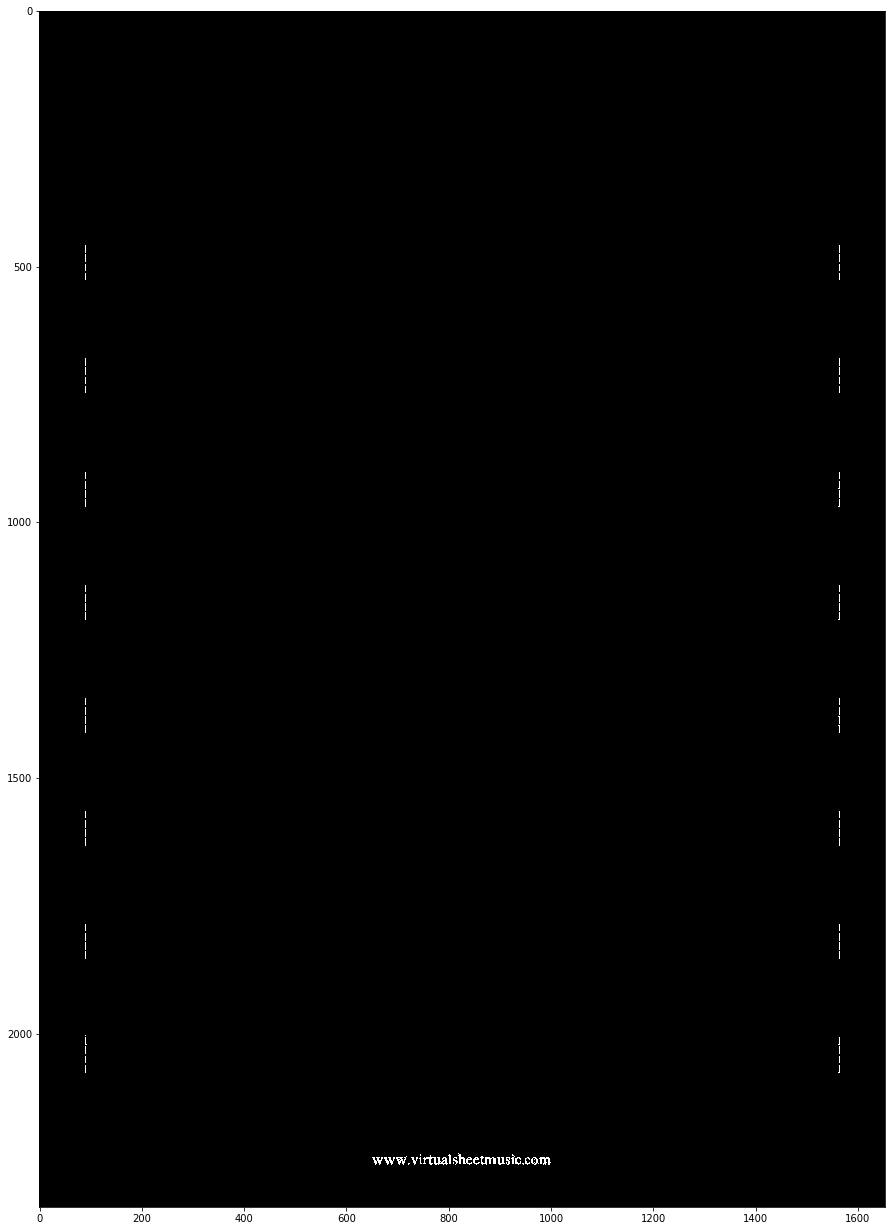

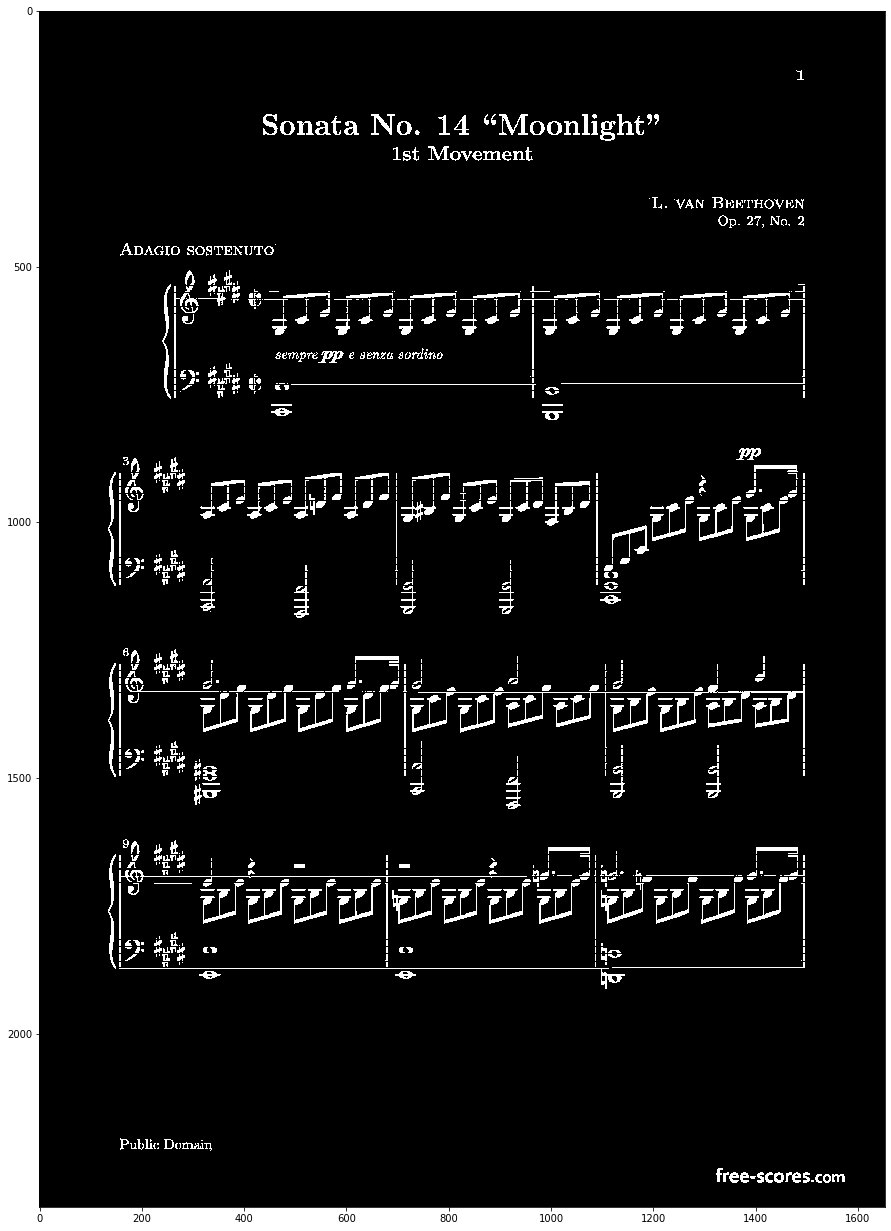

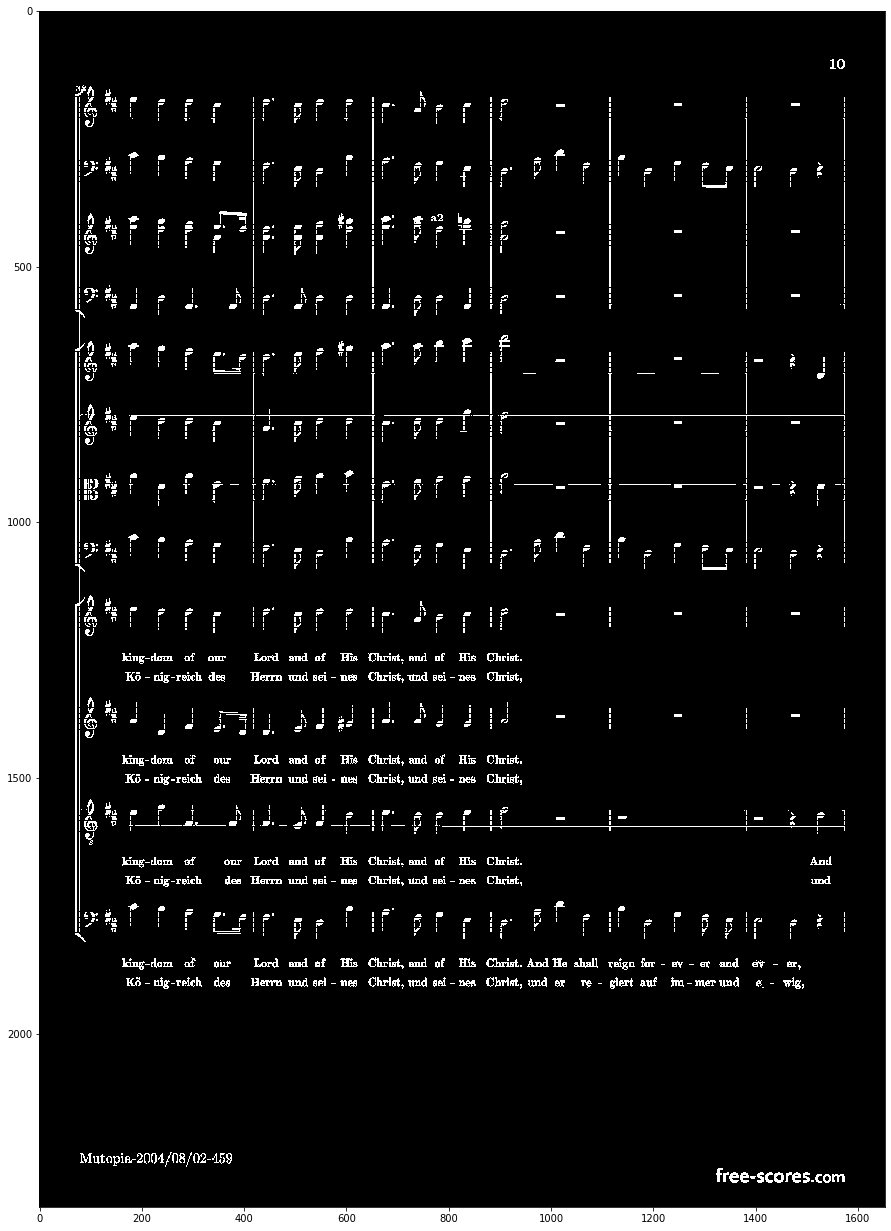

In [11]:
#Bierze imidż zarotowany równolegle do górnej krawędzi obrazka
def distinct(arr):
    st=sorted(arr, key=lambda x:x[0])
    j=0
    dist=1
    while (j<len(arr)):
        if (0.8*arr[0][1]>arr[j][1]):
            break
        if (j>0 and arr[j][0]-arr[j-1][0]>3):
            dist+=1
        j+=1
    return (1 if dist>=5 else 0)
    


def detect_5(bwimg):
    cs=0
    jj=0
    bethon=[0]*1000
    x=0
    cdis=80
    v1, v2=10, cdis+10
    
    while (x<len(bwimg)-v1):
        svv=((255-bwimg[x:x+cdis,:])//255).astype('int32')
        svg=(sorted(np.sum(svv, axis=1), reverse=1))
        stv=zip(range(x, x+cdis), np.sum(svv, axis=1))
        stv=(sorted(stv, key=lambda x:x[1], reverse=1))
        
        svv2=((255-bwimg[x+v1:x+v2,:])//255).astype('int32')
        svg2=(sorted(np.sum(svv2, axis=1), reverse=1))
        stv2=zip(range(x+v1, x+v2), np.sum(svv2, axis=1))
        stv2=(sorted(stv2, key=lambda x:x[1], reverse=1))
        
        #Ta heura na razie jest koszmarna i nieuniwersalizowalna, choć idea pewnie dobra
        if (len(svg2)>5 and svg[4]==svg2[4] and svg[4]>0.6*bwimg.shape[1] and distinct(stv)==1):
            bethon[jj]=(x+5, x+cdis+5, stv2[:15])
            jj+=1
            x+=cdis
        else:
            x+=1
    return (bethon[:jj])

def blackening(bwimg, pathway_of_decay):
    for i in range(len(pathway_of_decay)):
        bwimg[pathway_of_decay[i][0], pathway_of_decay[i][1]]=255

def pathfinder(bwimg, fals, dead, yla, ylc, x):
    slain=0
    im=bwimg[yla:ylc+1,x]
    if (im[1]==255 and (im[0]==0 or im[2]==0)):
        fals+=1
        dead=0
    elif(im[1]==255):
        dead+=1
    else:
        fals, dead=0, 0

    if (fals==3):
        fals=0
        if (im[0]==0):
            yla, ylc=yla-1, ylc-1
        else:
            yla, ylc=yla+1, ylc+1
    if (dead==3):
        dead=0
        slain=1
    return(fals, dead, slain, yla, ylc)
    
def findlinez(bwimg):
    y=0
    x1=bwimg.shape[1]//2-2
    x2=bwimg.shape[1]//2+2
    
    while (y<bwimg.shape[0]):
        vs=bwimg[y,x1:x2+1]
        if (0 in vs):
            xl=bwimg.shape[1]//2
            yla, ylc=y-1, y+1
            xr=xl
            
            pathway=[]
            fals, dead, slain=0, 0, 0
            while (xl>0):
                fals, dead, slain, yla, ylc=pathfinder(bwimg, fals, dead, yla, ylc, xl)
                pathway.append((yla+1, xl))
                if (slain==1):
                    break
                xl-=1
            
            fals, dead, slain=0, 0, 0
            yla, ylc=y-1, y+1
            while (xr<bwimg.shape[1]):
                fals, dead, slain, yla, ylc=pathfinder(bwimg, fals, dead, yla, ylc, xr)
                pathway.append((yla+1, xr))
                if (slain==1):
                    break
                xr+=1
            if (xr-xl>1000):
                blackening(bwimg, pathway)
        y+=1


kernel=[0]*10
#kernele do grafiki
kernel[1]=np.asarray([[-1, -1, -1], [-1,8,-1], [-1, -1, -1]])
kernel[2]=np.asarray([[0, 1, 0], [1,-4,1], [0, 1, 0]])
kernel[3]=np.asarray([[0, 1, 0], [1,-5,1], [0, 1, 0]])
kernel[4]=(1/9)*np.asarray([[1, 1, 1], [1,1,1], [1, 1, 1]])
kernel[5]=(1/16)*np.asarray([[1, 2, 1], [2,4,2], [1, 2, 1]])
kernel[6]=(1/256)*np.asarray([[1,4,6,4,1], [4,16,24,16,4], [6,24,36,24,6], [4,16,24,16,4], [1,4,6,4,1]])
dm=(7,7)
kernel[7]=np.asarray([[1 for j in range(dm[0])] for i in range(dm[1])])
kernel[8]=np.asarray([[0, -1, 0], [-1,5,-1], [0, -1, 0]])

for i in range(20):
    ###BINARIZATION
    img=f[i].copy()
    mg=cv.filter2D(img, -1, kernel[5])
    mg2=cv.filter2D(img, -1, kernel[4])
    #mg=cv.filter2D(mg, -1, kernel[5])
    im2=cv.filter2D(mg, -1, kernel[2])
    im3=cv.filter2D(mg2, -1, kernel[1])
    #grave(im2, 1)
    #grave(im3, 1)
    im4=cv.filter2D(im3, -1, kernel[7])
    #grave(im4, 1)
    
    img2=cv.adaptiveThreshold(img, 255, cv.ADAPTIVE_THRESH_GAUSSIAN_C, cv.THRESH_BINARY, 145, 1)
    #img2[im4<140]=255
    #grave(img2, 1)
    #grave(img, 1)
    
    
    
    ###Linez - Only horizontal hier
    ##
    ##
    
    ###DETECTION
    
    fig, ax=plt.subplots(1,1,figsize=(22,22))
    findlinez(img2)
    
    ax.imshow(img2, cmap='Greys',  interpolation='nearest')
    plt.show()

In [ ]:
#### 

In [ ]:
##Bardzo efektywny do pdfów
kernel=[0]*10
#kernele do grafiki
kernel[1]=np.asarray([[-1, -1, -1], [-1,8,-1], [-1, -1, -1]])
kernel[2]=np.asarray([[0, 1, 0], [1,-4,1], [0, 1, 0]])
kernel[3]=np.asarray([[0, 1, 0], [1,-5,1], [0, 1, 0]])
kernel[4]=(1/9)*np.asarray([[1, 1, 1], [1,1,1], [1, 1, 1]])
kernel[5]=(1/16)*np.asarray([[1, 2, 1], [2,4,2], [1, 2, 1]])
kernel[6]=(1/256)*np.asarray([[1,4,6,4,1], [4,16,24,16,4], [6,24,36,24,6], [4,16,24,16,4], [1,4,6,4,1]])
dm=(7,7)
kernel[7]=np.asarray([[1 for j in range(dm[0])] for i in range(dm[1])])
kernel[8]=np.asarray([[0, -1, 0], [-1,5,-1], [0, -1, 0]])


for i in range(j):
    img=f[i].copy()
    grayscaled = cv.cvtColor(img,cv.COLOR_BGR2GRAY)
    img2=cv.adaptiveThreshold(grayscaled, 255, cv.ADAPTIVE_THRESH_GAUSSIAN_C, cv.THRESH_BINARY, 35, 1)
    grave(img2)
    grave(img)